# Imports & df's

In [42]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from source import config
from source import utils

df_single = pd.read_csv(config.INTERIM_DATA_DIR / 'Enkeltaksler axle load distribution.csv') 
df_boggi = pd.read_csv(config.INTERIM_DATA_DIR / 'Boggiaksler axle load distribution.csv') 
df_triple = pd.read_csv(config.INTERIM_DATA_DIR / 'Trippelaksler axle load distribution.csv') 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Constants

In [43]:
label_x_axis = 'Tonn'
label_y_axis = 'Prosent av den totale fordelingen'
title_multiple = 'Aksellastfordeling for samtlige konfigurasjoner (total, alle lokasjoner)'
title_multiple_n200 = f'{title_multiple}, sammenliknet med N200'
title_multiple_esal = f'{title_multiple_n200} og ekvivalensfaktor'
end_title_lineplot = ', lineplot'
end_title_barplot = ', barplot'

ax1_legend_config_base = {
    'loc': 'upper center',
    'bbox_to_anchor': (0.625, 1),
    'ncol': 1,
}
ax_1_legened_config_single = {
    'title': 'Prosent av fordelingen',
    **ax1_legend_config_base
}
ax_1_legened_config_multiple = {
    'title': 'Prosent av fordelingen\nfor hver akselkonfigurasjon',
    **ax1_legend_config_base
}
ax2_legend_config = {
    'title': 'Ekvivalensfaktor',
    'loc': 'upper center',
    'bbox_to_anchor': (0.8, 1),
    'ncol': 1
}

bar_width_n200 = 0.90
bar_width_axle = 0.2

color = {
    'enkeltaksel': 'dodgerblue',
    'boggiaksel': 'fuchsia',
    'trippelaksel': 'lime',
    'N200': 'darkorange',
    'esal': 'black'
}
opacity_n200 = 0.5

plot = True
save_fig = True

# Variables

In [44]:
tonnage_categories = df_single.columns[1:]
df_single_total = df_single[df_single['Sted'] == 'Total'][tonnage_categories].values.flatten()
df_boggi_total = df_boggi[df_boggi['Sted'] == 'Total'][tonnage_categories].values.flatten()
df_triple_total = df_triple[df_triple['Sted'] == 'Total'][tonnage_categories].values.flatten()

n200_categories = list(config.Axle_load_distribution_10_ton_road_percentage_N200.keys())
n200_values = list(config.Axle_load_distribution_10_ton_road_percentage_N200.values())

axle_group_k_values = {
    'enkeltaksel': 1,
    'boggiaksel': (10/18)**4,
    'trippelaksel': (10/24)**4
}

esal = lambda w, axle_group: ((w / 10)**4) * axle_group_k_values[axle_group]
esal_x = np.linspace(0, 30, 1000)

delta_total_values = 10e-3

# Plotting code

In [45]:
def plot_bars(ax, x_positions, values, width, label, color, zorder, alpha=1.0):
    ax.bar(x_positions, values, width=width, label=label, color=color, zorder=zorder, alpha=alpha)

def add_esal_line(ax, x_data, axle_type, color, linewidth, legend_config):
    ax2 = ax.twinx()
    esal_y = esal(x_data, axle_type)
    ax2.plot(x_data, esal_y, label='Ekvivalensfaktor', color=color, linewidth=linewidth)
    ax2.set_ylabel('Ekvivalensfaktor')
    ax2.legend(**legend_config)
    ax2.set_ylim(bottom=0)
    return ax2

def set_common_plot_attributes(ax, title, xlabel, ylabel, xticks, xticklabels, legend_config):
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels, rotation=90)
    ax.legend(**legend_config)

def plot_individual_bars(df, axle_type, mode='default'):
    fig, ax1 = plt.subplots(figsize=(12, 6))
    bar_width = 0.4

    axle_totals = {
        'enkeltaksel': df_single_total,
        'boggiaksel': df_boggi_total,
        'trippelaksel': df_triple_total
    }

    if axle_type not in axle_totals:
        raise ValueError("Invalid axle_type.")

    total_values = axle_totals[axle_type]
    total_values, threshold_index = utils.trim_tonnage_x_axis(total_values=total_values, delta=delta_total_values)

    tonnage_categories_list = list(tonnage_categories)[:threshold_index]
    x_positions = np.arange(len(tonnage_categories_list))

    plot_bars(ax1, x_positions, total_values, bar_width, 'Totalt, alle lokasjoner', color[axle_type], zorder=2)

    if mode in ['N200', 'esal']:
        n200_x_positions = [tonnage_categories_list.index(cat) for cat in n200_categories if cat in tonnage_categories_list]
        plot_bars(ax1, n200_x_positions, n200_values, bar_width_n200, 'N200', color['N200'], zorder=1, alpha=opacity_n200)

    if mode == 'esal':
        cur_esal_x = esal_x[esal_x < threshold_index]
        add_esal_line(ax1, cur_esal_x, axle_type, color['esal'], 2, ax2_legend_config)

    title = f"Aksellastfordeling for {axle_type} (Totalt, alle lokasjoner)" + \
            (', sammenliknet med N200' if mode in ['N200', 'esal'] else '') + \
            (' og ekvivalensfaktor' if mode == 'esal' else '')

    set_common_plot_attributes(ax1, title, label_x_axis, label_y_axis, x_positions, tonnage_categories_list, ax_1_legened_config_single)

    if save_fig:
        plt.savefig(config.FIGURES_DIR / f'{title}.png')
    if plot:
        plt.tight_layout()
        plt.show()

def plot_combined_value_bars(mode='default'):
    fig, ax1 = plt.subplots(figsize=(12, 6))

    tonnage_categories_list = list(tonnage_categories)
    x_positions = np.arange(len(tonnage_categories_list))

    if mode in ['N200', 'esal']:
        n200_x_positions = [tonnage_categories_list.index(cat) for cat in n200_categories if cat in tonnage_categories_list]
        plot_bars(ax1, n200_x_positions, n200_values, bar_width_n200, 'N200', color['N200'], zorder=1, alpha=opacity_n200)

    plot_bars(ax1, x_positions - bar_width_axle, df_single_total, bar_width_axle, 'enkeltaksel', color['enkeltaksel'], zorder=2)
    plot_bars(ax1, x_positions, df_boggi_total, bar_width_axle, 'boggiaksel', color['boggiaksel'], zorder=2)
    plot_bars(ax1, x_positions + bar_width_axle, df_triple_total, bar_width_axle, 'trippelaksel', color['trippelaksel'], zorder=2)

    if mode == 'esal':
        cur_esal_x = esal_x[esal_x < len(tonnage_categories_list)]
        add_esal_line(ax1, cur_esal_x, 'enkeltaksel', color['esal'], 2, ax2_legend_config)

    title = title_multiple if mode == 'default' else title_multiple_n200 if mode == 'N200' else title_multiple_esal
    title += end_title_barplot
    set_common_plot_attributes(ax1, title, label_x_axis, label_y_axis, x_positions, tonnage_categories_list, ax_1_legened_config_multiple)
    
    if save_fig:
        plt.savefig(config.FIGURES_DIR / f'{title}.png')
    if plot:
        plt.tight_layout()
        plt.show()

def plot_line_chart(mode='default'):
    fig, ax1 = plt.subplots(figsize=(12, 6))

    tonnage_categories_list = list(tonnage_categories)
    x_positions = range(len(tonnage_categories_list))

    ax1.plot(tonnage_categories_list, df_single_total, label='enkeltaksel', marker='o', color=color['enkeltaksel'])
    ax1.plot(tonnage_categories_list, df_boggi_total, label='boggiaksel', marker='s', color=color['boggiaksel'])
    ax1.plot(tonnage_categories_list, df_triple_total, label='trippelaksel', marker='^', color=color['trippelaksel'])

    if mode in ['N200', 'esal']:
        n200_x_positions = [tonnage_categories_list.index(cat) for cat in n200_categories if cat in tonnage_categories_list]
        plot_bars(ax1, n200_x_positions, n200_values, bar_width_n200, 'N200', color['N200'], zorder=1, alpha=opacity_n200)

    if mode == 'esal':
        cur_esal_x = esal_x[esal_x < len(tonnage_categories_list)]
        add_esal_line(ax1, cur_esal_x, 'enkeltaksel', color['esal'], 2, ax2_legend_config)

    title = title_multiple if mode == 'default' else title_multiple_n200 if mode == 'N200' else title_multiple_esal
    title += end_title_lineplot

    set_common_plot_attributes(ax1, title, label_x_axis, label_y_axis, x_positions, tonnage_categories_list, ax_1_legened_config_multiple)
    
    if save_fig:
        plt.savefig(config.FIGURES_DIR / f'{title}.png')
    if plot:
        plt.tight_layout()
        plt.show()
        

# Plotting

## Solely axle loads

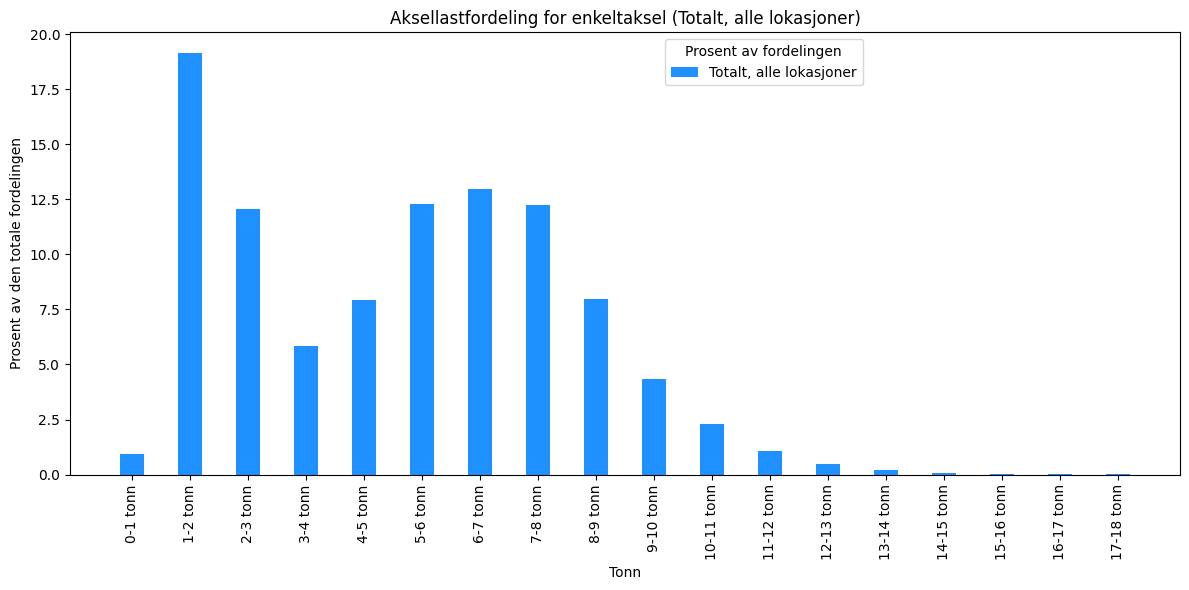

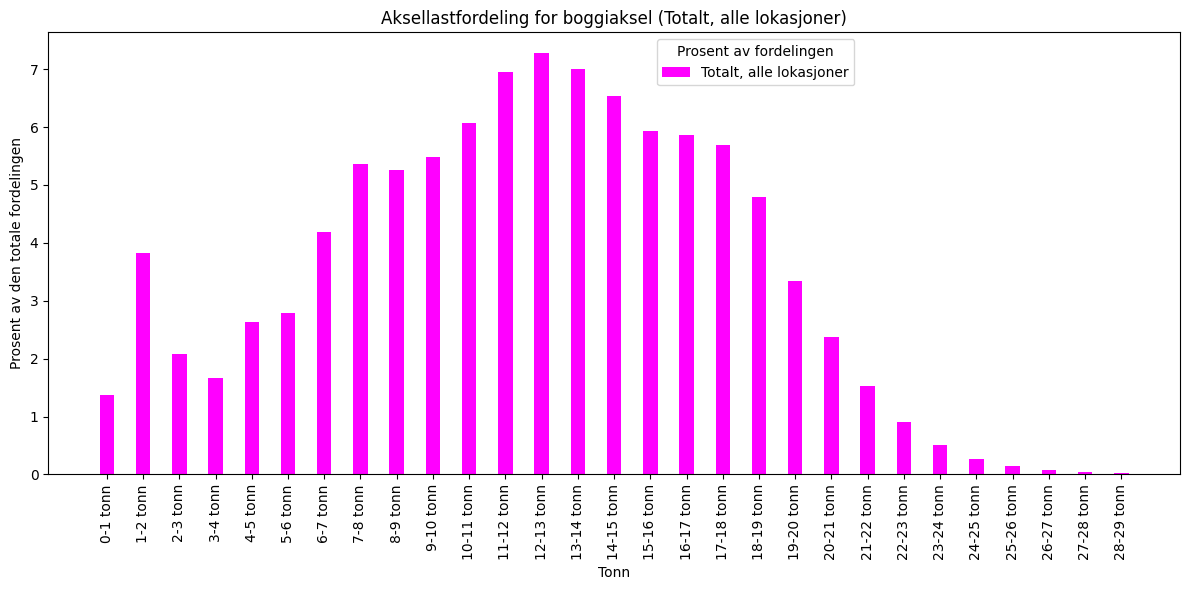

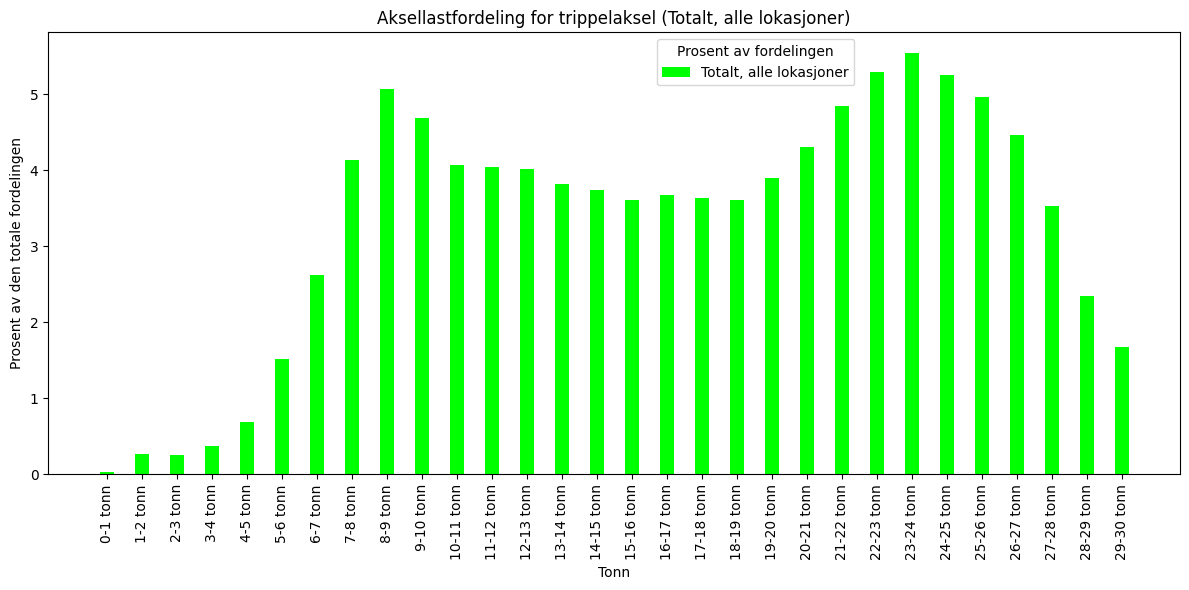

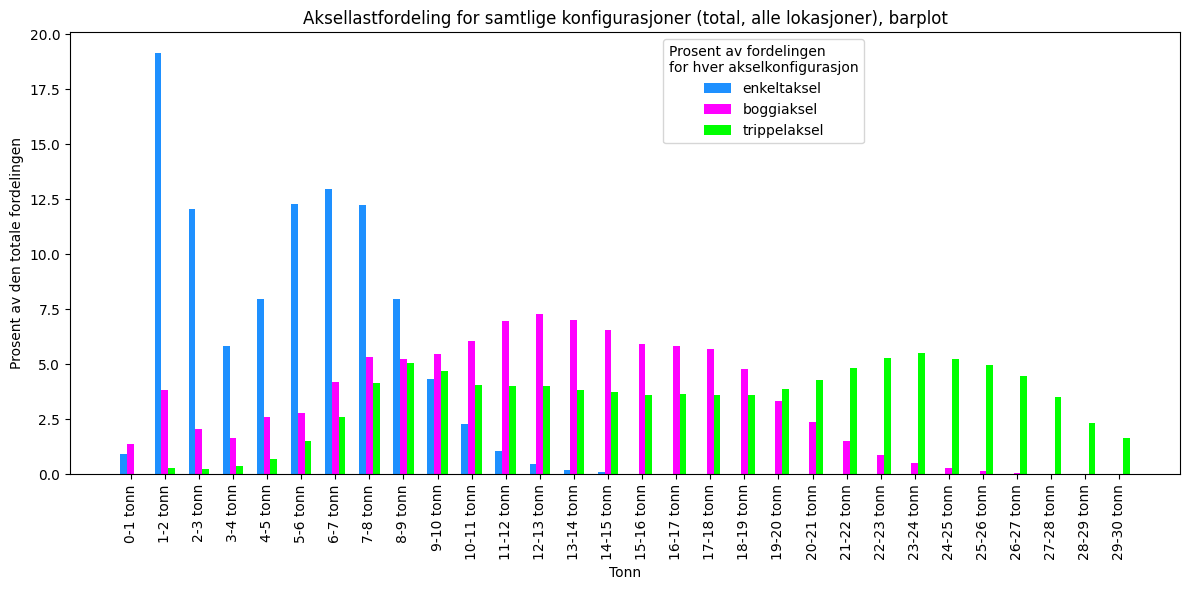

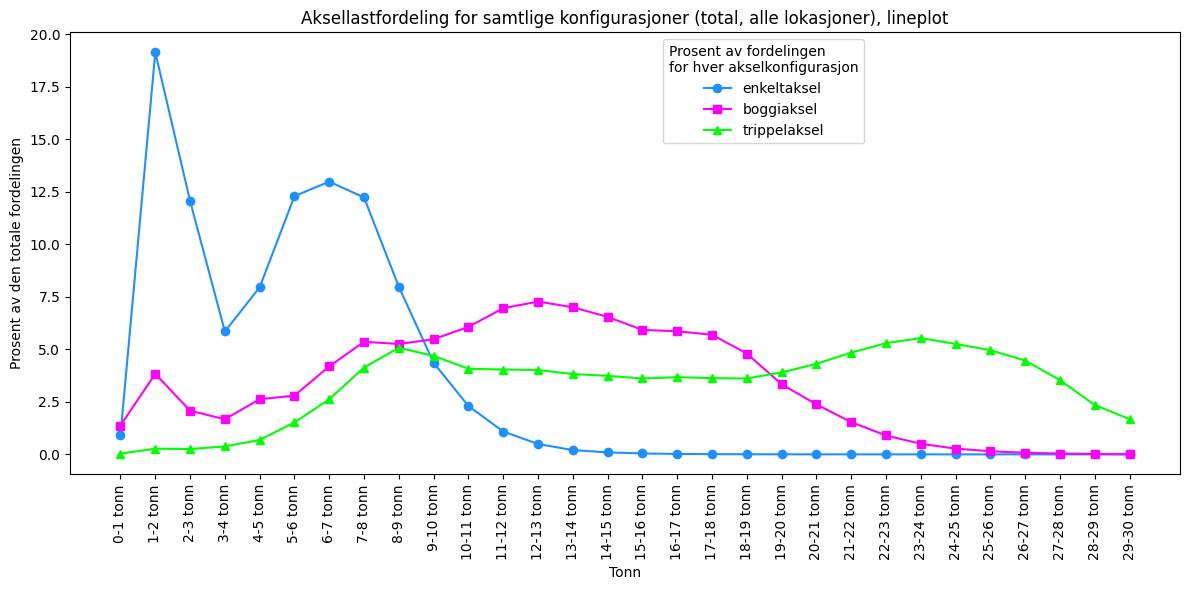

In [46]:
plot_individual_bars(df_single, 'enkeltaksel', mode='default')
plot_individual_bars(df_boggi, 'boggiaksel', mode='default')
plot_individual_bars(df_triple, 'trippelaksel', mode='default')
plot_combined_value_bars(mode='default')
plot_line_chart(mode='default')

## Axle loads with N200

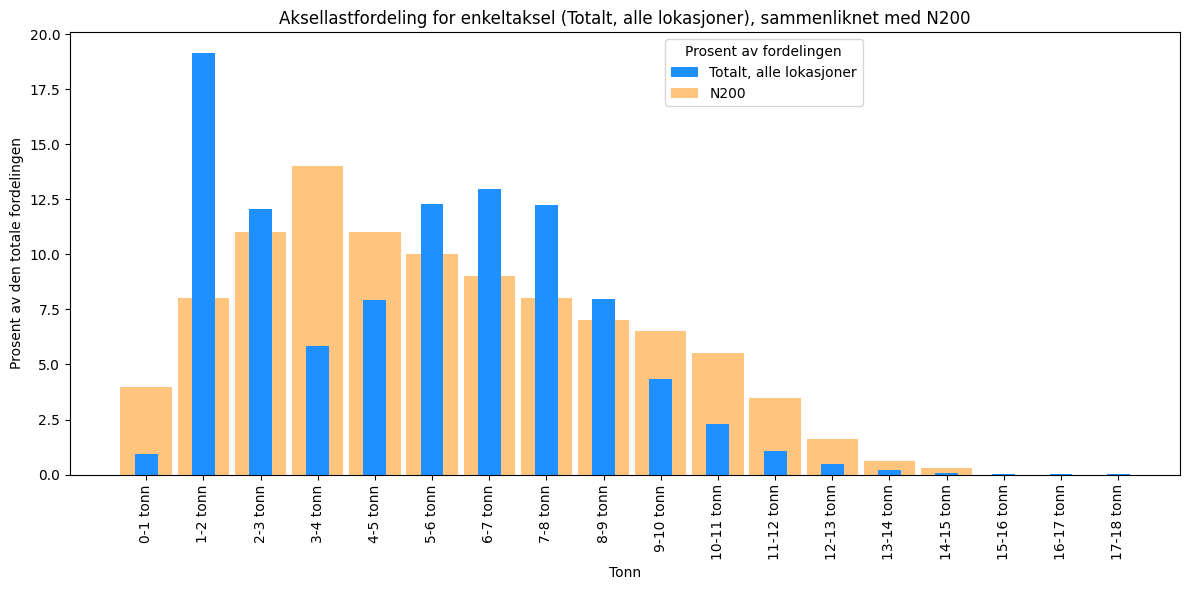

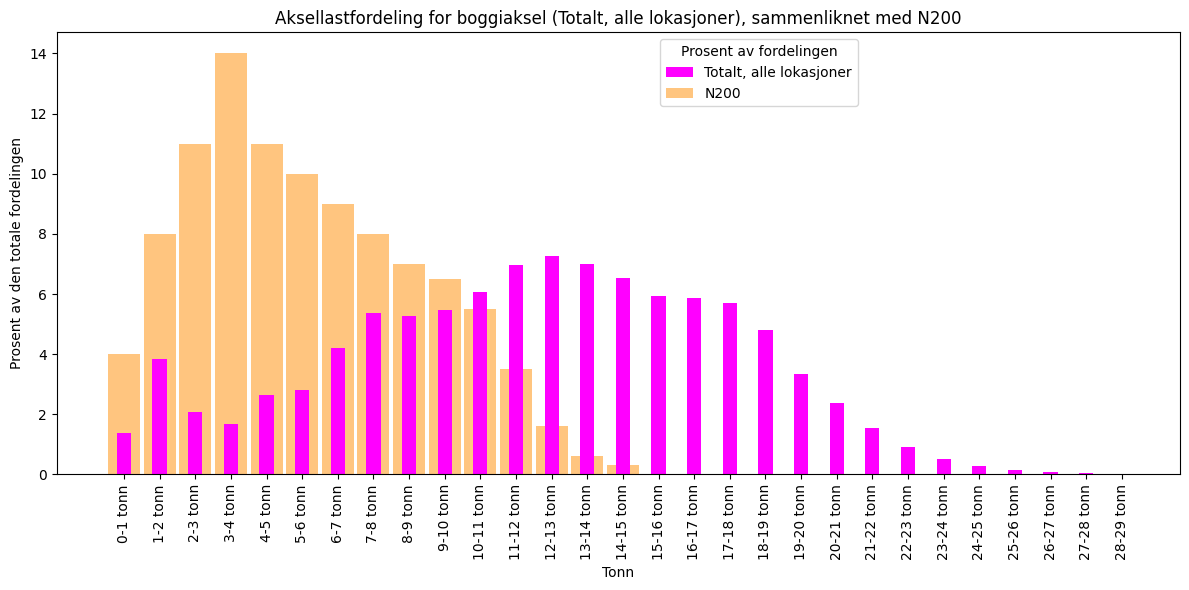

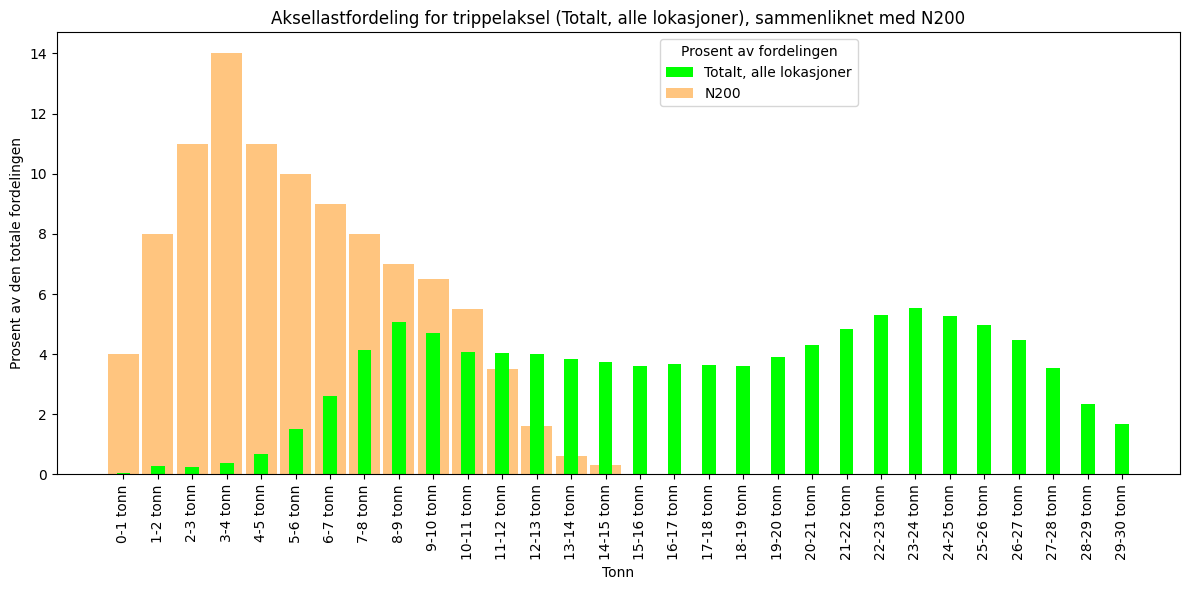

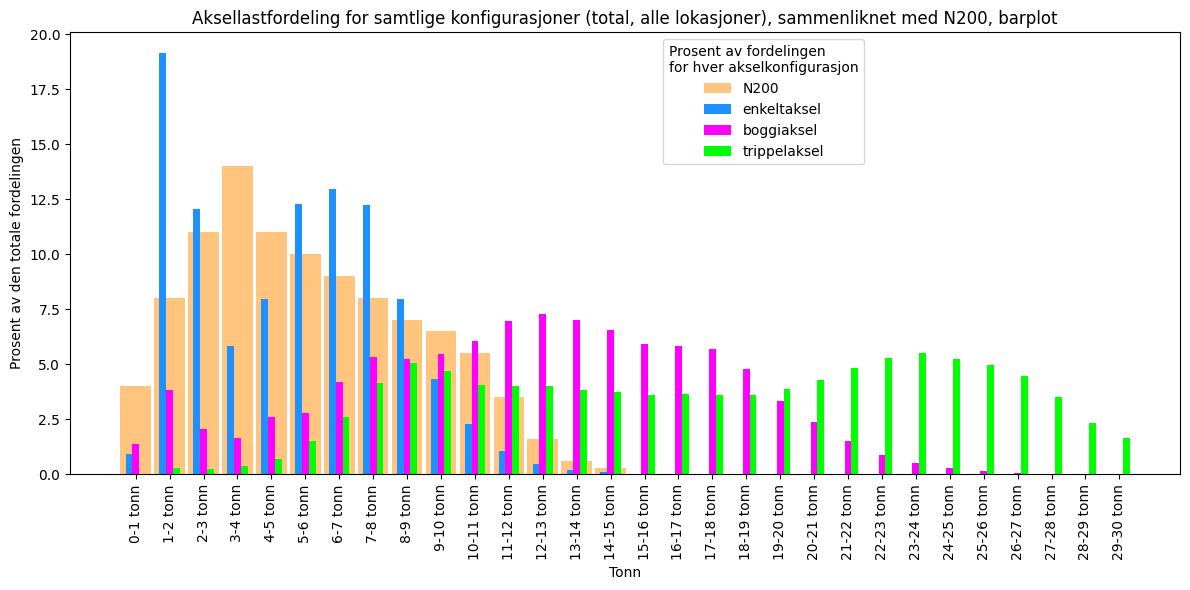

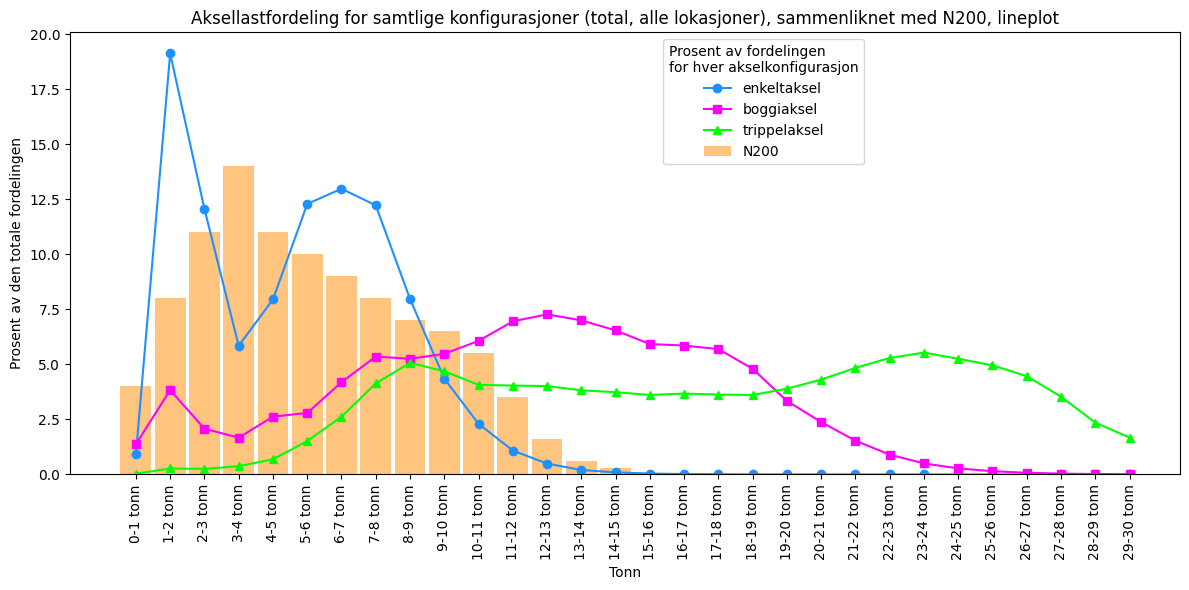

In [47]:
plot_individual_bars(df_single, 'enkeltaksel', mode='N200')
plot_individual_bars(df_boggi, 'boggiaksel', mode='N200')
plot_individual_bars(df_triple, 'trippelaksel', mode='N200')
plot_combined_value_bars(mode='N200')
plot_line_chart(mode='N200')

## Axle loads with N200 and ESAL

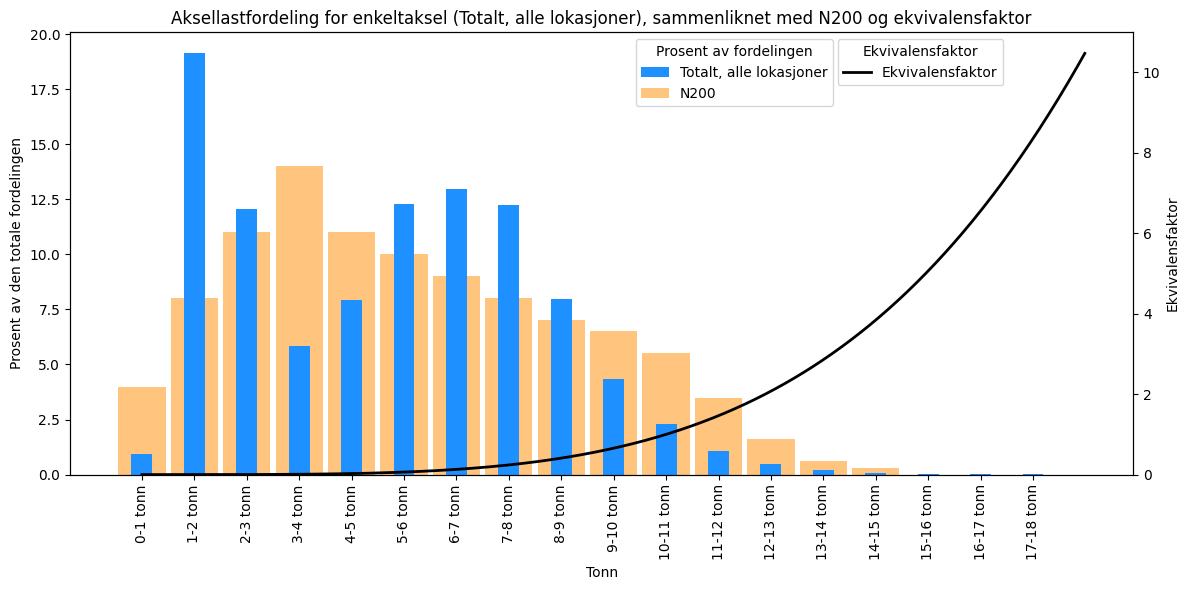

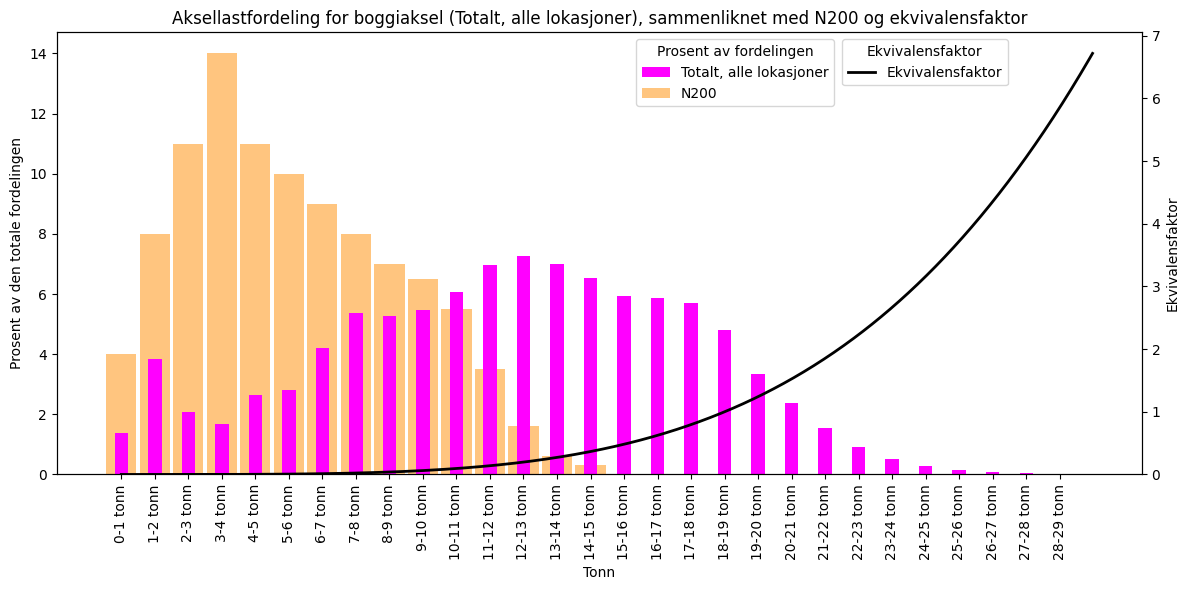

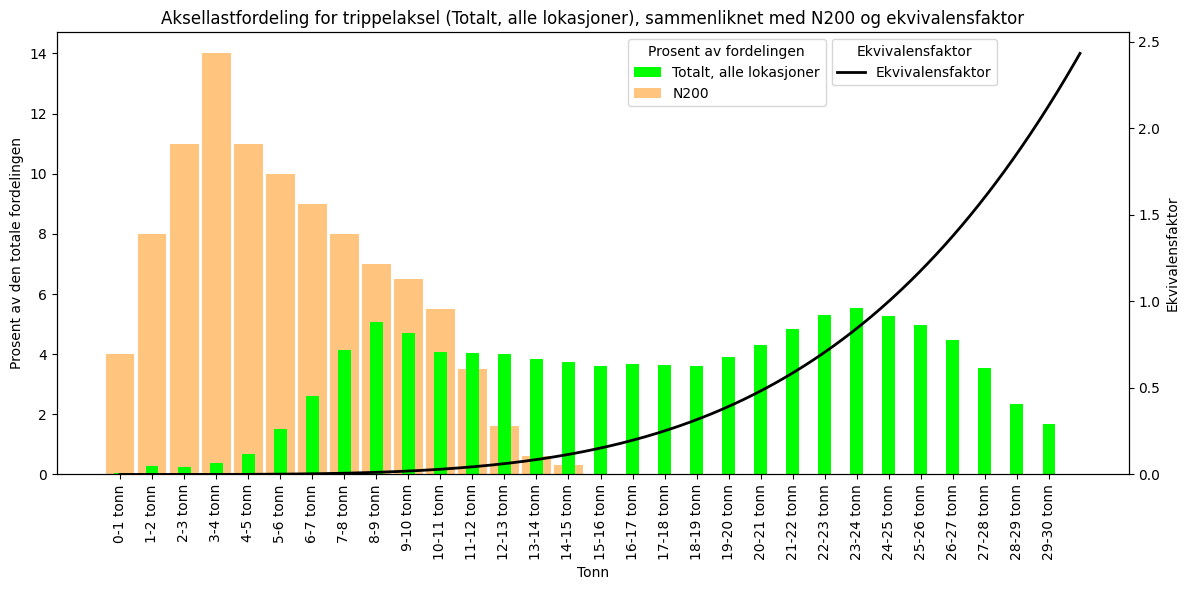

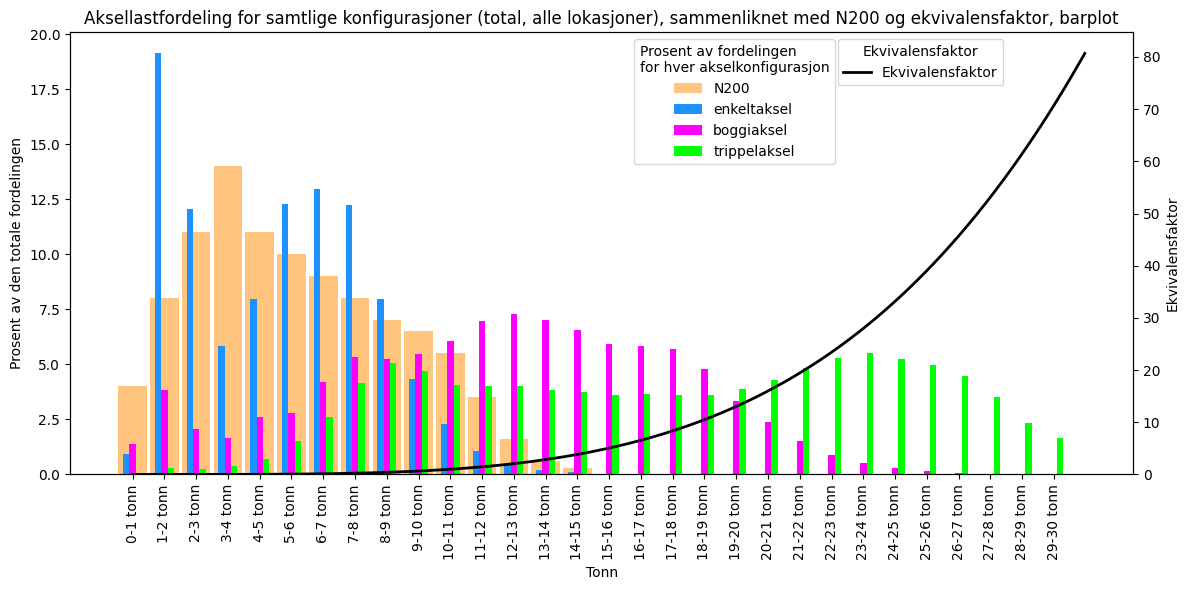

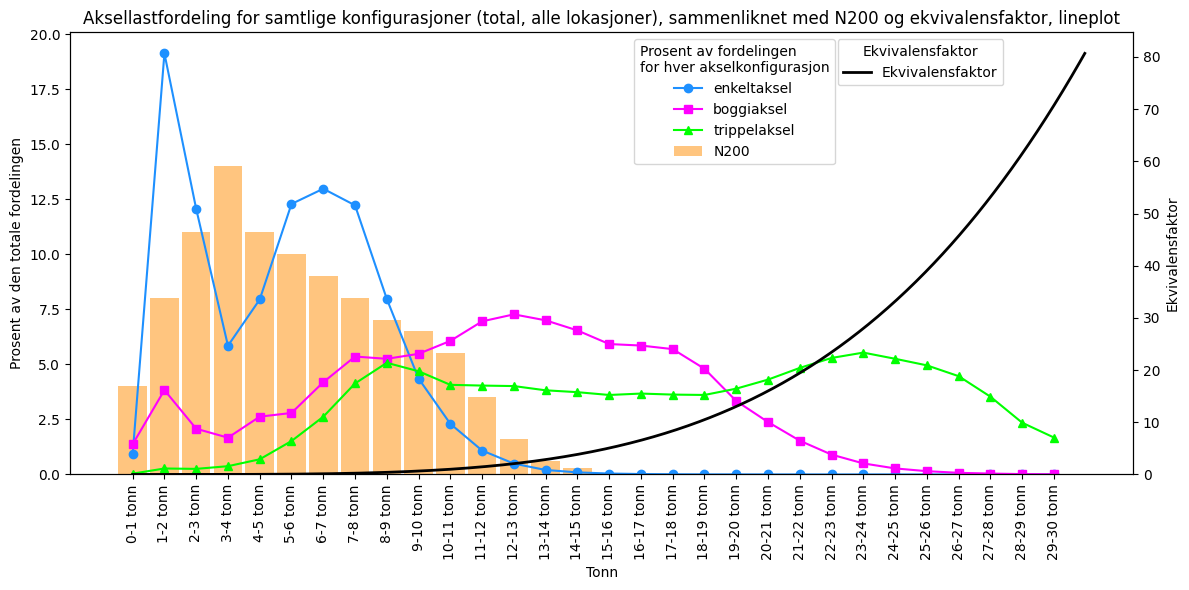

In [48]:
plot_individual_bars(df_single, 'enkeltaksel', mode='esal')
plot_individual_bars(df_boggi, 'boggiaksel', mode='esal')
plot_individual_bars(df_triple, 'trippelaksel', mode='esal')
plot_combined_value_bars(mode='esal')
plot_line_chart(mode='esal')

In [49]:
print(config.FIGURES_DIR / f'{title_multiple_esal}, lineplot.png')

/home/anders/source/reports/figures/Aksellastfordeling for samtlige konfigurasjoner (total, alle lokasjoner), sammenliknet med N200 og ekvivalensfaktor, lineplot.png
